In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models

from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Deep-learning/final project')

In [4]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

In [5]:
def plot_prediction(y_test, y_pred, title, r2, mse, scorr):
  plt.figure(figsize=(8, 8))
  sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
  plt.xlabel('True Values (y_test)')
  plt.ylabel('Predicted Values (y_pred)')
  plt.title(title)
  plt.grid(True)
  plt.figtext(0.75, 0.21, f'MSE: {mse:.3f}', horizontalalignment='left', fontsize=11)
  plt.figtext(0.75, 0.18, f'R\u00B2: {r2:.3f}', horizontalalignment='left', fontsize=11)
  plt.figtext(0.75, 0.15, f'Corr: {scorr:.3f}', horizontalalignment='left', fontsize=11)
  plt.show()

In [6]:
wt = pd.read_csv('WT/WT.csv')
wt.head()

,sgRNA,indel
0,AAAAAAAAACTCCAAAACCCTGG,0.168570
1,AAAAAACAACAAGAAGCACAAGG,0.099624
2,AAAAAACACAAGCAAGACCGTGG,0.247750
3,AAAAAACAGATGCCACCTGTGGG,0.141232
4,AAAAAACCCGTAGATAGCCTCGG,0.045803


In [ ]:
len(wt)

55603

In [7]:
sgRNA_split = wt['sgRNA'].apply(lambda x: list(x))
sgRNA_split = pd.DataFrame(sgRNA_split.tolist())
sgRNA_split.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,A,A,A,A,A,A,A,A,A,C,...,A,A,A,A,C,C,C,T,G,G
1,A,A,A,A,A,A,C,A,A,C,...,A,A,G,C,A,C,A,A,G,G
2,A,A,A,A,A,A,C,A,C,A,...,A,A,G,A,C,C,G,T,G,G
3,A,A,A,A,A,A,C,A,G,A,...,C,A,C,C,T,G,T,G,G,G
4,A,A,A,A,A,A,C,C,C,G,...,A,T,A,G,C,C,T,C,G,G


In [8]:
from sklearn.preprocessing import LabelEncoder

sgRNA_split_encoded = sgRNA_split.copy()
label_encoders = {}

for col in sgRNA_split_encoded.columns:
    le = LabelEncoder()
    sgRNA_split_encoded[col] = le.fit_transform(sgRNA_split_encoded[col])
    label_encoders[col] = le

sgRNA_split_encoded = sgRNA_split_encoded.iloc[:, :-2] # Exclude the last two columns
sgRNA_split_encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,1,1,1,3
1,0,0,0,0,0,0,1,0,0,1,...,0,2,0,0,2,1,0,1,0,0
2,0,0,0,0,0,0,1,0,1,0,...,2,1,0,0,2,0,1,1,2,3
3,0,0,0,0,0,0,1,0,2,0,...,2,1,1,0,1,1,3,2,3,2
4,0,0,0,0,0,0,1,1,1,2,...,0,2,0,3,0,2,1,1,3,1


In [9]:
sgRNA_label = pd.concat([wt.drop('sgRNA', axis=1), sgRNA_split_encoded], axis=1)
sgRNA_label.head()

,indel,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,0.168570,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,1,1,3
1,0.099624,0,0,0,0,0,0,1,0,0,...,0,2,0,0,2,1,0,1,0,0
2,0.247750,0,0,0,0,0,0,1,0,1,...,2,1,0,0,2,0,1,1,2,3
3,0.141232,0,0,0,0,0,0,1,0,2,...,2,1,1,0,1,1,3,2,3,2
4,0.045803,0,0,0,0,0,0,1,1,1,...,0,2,0,3,0,2,1,1,3,1


In [10]:
from sklearn.model_selection import train_test_split

X = sgRNA_label.drop('indel', axis=1)
y = sgRNA_label['indel']

y_binned = pd.cut(y, bins=10, labels=False, include_lowest=True)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

y_temp_binned = pd.cut(y_temp, bins=10, labels=False, include_lowest=True)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp_binned)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (44482, 21)
y_train shape: (44482,)
X_val shape: (5560, 21)
y_val shape: (5560,)
X_test shape: (5561, 21)
y_test shape: (5561,)


In [11]:
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f'X_train_reshaped shape: {X_train_reshaped.shape}')
print(f'X_val_reshaped shape: {X_val_reshaped.shape}')
print(f'X_test_reshaped shape: {X_test_reshaped.shape}')

X_train_reshaped shape: (44482, 21, 1)
X_val_reshaped shape: (5560, 21, 1)
X_test_reshaped shape: (5561, 21, 1)


### Model 7: attention mechanism

In [12]:
inputs = tf.keras.Input(shape=(X_train.shape[1],), dtype="int64")
embedded = layers.Embedding(input_dim=4, output_dim=16)(inputs)
x = layers.Attention()([embedded, embedded])
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="MSE")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 21, 16)    │         64 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 21, 16)    │          0 │ embedding[0][0],  │
│ (Attention)         │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 336)       │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     21,568 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,697 (84.75 KB)

 Trainable params: 21,697 (84.75 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("WT/attn.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=callbacks)

Epoch 1/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0499 - val_loss: 0.0308
Epoch 2/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0289 - val_loss: 0.0228
Epoch 3/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0222 - val_loss: 0.0282
Epoch 4/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0217 - val_loss: 0.0213
Epoch 5/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0194 - val_loss: 0.0191
Epoch 6/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0181 - val_loss: 0.0179
Epoch 7/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0168 - val_loss: 0.0176
Epoch 8/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0158 - val_loss: 0.0166
Epoch 9/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0158 - val_loss: 0.0179
Epoch 10/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0154 - val_loss: 0.0163
Epoch 11/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0144 - val_loss: 0.0160
Epoch 12/200
1391

In [14]:
model = keras.models.load_model("WT/attn.keras")
model.evaluate(X_test_reshaped,y_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0157


0.015374685637652874

In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,val_loss
11,0.015,0.016
12,0.014,0.015
13,0.014,0.015
14,0.014,0.015
15,0.014,0.015


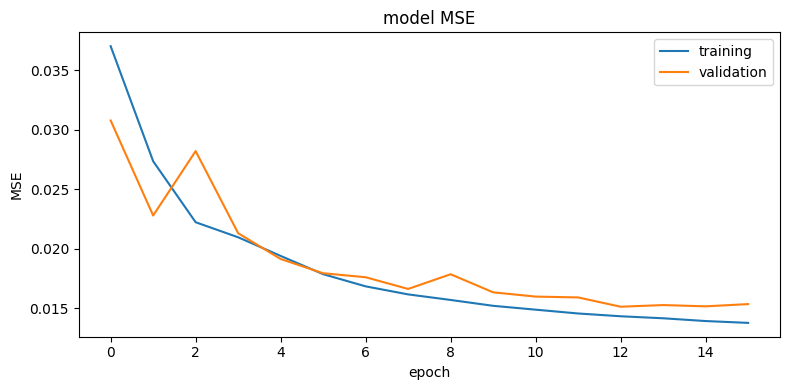

In [17]:
plt.figure(figsize=(8, 4))
display_training_curves(history_df['loss'], history_df['val_loss'], 'MSE',111)
plt.tight_layout()

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


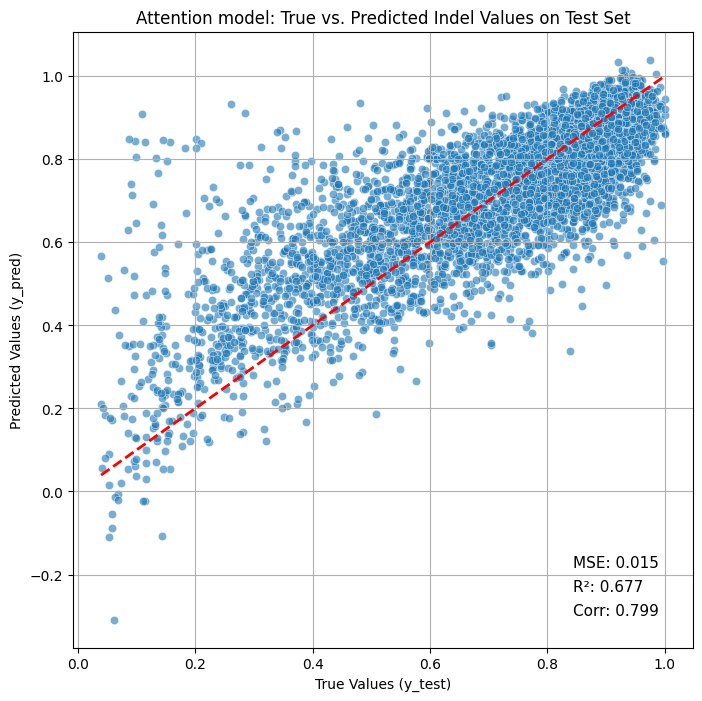

In [20]:
y_pred = model.predict(X_test_reshaped).flatten()

mse = model.evaluate(X_test_reshaped, y_test, verbose=0)
r2 = r2_score(y_test, y_pred)
scorr = spearmanr(y_test, y_pred).correlation

plot_prediction(y_test, y_pred, title='Attention model: True vs. Predicted Indel Values on Test Set', r2=r2, mse=mse, scorr=scorr)

In [21]:
results_df = pd.DataFrame({'True_Value': y_test, 'Predicted_Value': y_pred}, index=y_test.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 107
       True_Value  Predicted_Value
47133    0.393903         0.688199
31268    0.284127         0.663427
37780    0.152561         0.794835
15762    0.098945         0.646096
50700    0.393615         0.638642


### Model 8: BiLSTM with attention mechanism

In [ ]:
inputs = tf.keras.Input(shape=(X_train.shape[1],), dtype="int64")
embedded = layers.Embedding(input_dim=4, output_dim=16)(inputs)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(embedded)
x = layers.Attention()([x, x])
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="MSE")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 21, 16)    │         64 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 21, 64)    │     12,544 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 21, 64)    │          0 │ bidirectional_2[… │
│ (Attention)         │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1344)      │          0 │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     86,080 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 98,753 (385.75 KB)

 Trainable params: 98,753 (385.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("WT/LSTM_attn.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=callbacks)

Epoch 1/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 47s 24ms/step - loss: 0.0481 - val_loss: 0.0303
Epoch 2/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - loss: 0.0283 - val_loss: 0.0261
Epoch 3/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - loss: 0.0232 - val_loss: 0.0212
Epoch 4/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - loss: 0.0194 - val_loss: 0.0168
Epoch 5/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 0.0171 - val_loss: 0.0204
Epoch 6/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - loss: 0.0162 - val_loss: 0.0157
Epoch 7/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - loss: 0.0148 - val_loss: 0.0156
Epoch 8/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - loss: 0.0142 - val_loss: 0.0151
Epoch 9/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - loss: 0.0137 - val_loss: 0.0153
Epoch 10/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - loss: 0.0130 - val_loss: 0.0136
Epoch 11/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - loss: 0.0126 - val_loss: 0.01

In [ ]:
model = keras.models.load_model("WT/LSTM_attn.keras")
model.evaluate(X_test_reshaped,y_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0121


0.011696693487465382

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,val_loss
15,0.010,0.011
16,0.010,0.011
17,0.010,0.011
18,0.009,0.012
19,0.009,0.013


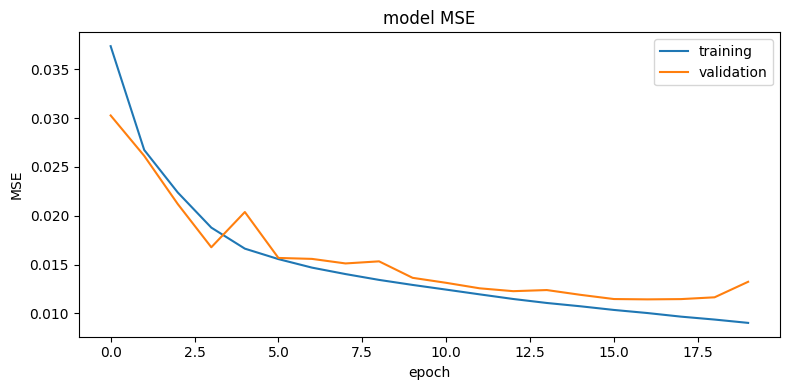

In [ ]:
plt.figure(figsize=(8, 4))
display_training_curves(history_df['loss'], history_df['val_loss'], 'MSE',111)
plt.tight_layout()

174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


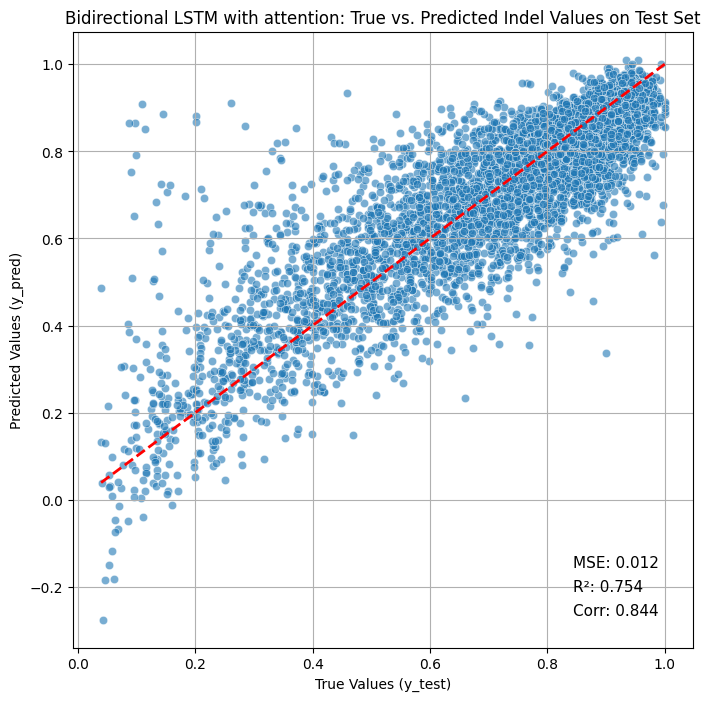

In [ ]:
y_pred = model.predict(X_test_reshaped).flatten()

mse = model.evaluate(X_test_reshaped, y_test, verbose=0)
r2 = r2_score(y_test, y_pred)
scorr = spearmanr(y_test, y_pred).correlation

plot_prediction(y_test, y_pred, title='Bidirectional LSTM with attention: True vs. Predicted Indel Values on Test Set', r2=r2, mse=mse, scorr=scorr)

In [ ]:
results_df = pd.DataFrame({'True_Value': y_test, 'Predicted_Value': y_pred}, index=y_test.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 62
       True_Value  Predicted_Value
31268    0.284127         0.622779
37780    0.152561         0.707057
30991    0.372418         0.852613
52291    0.369104         0.616797
42369    0.201679         0.881948


### Model 9: BiLSTM with multihead attention

In [23]:
inputs = tf.keras.Input(shape=(X_train.shape[1],), dtype="int64")
embedded = layers.Embedding(input_dim=4, output_dim=16)(inputs)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(embedded)
attn_output = layers.MultiHeadAttention(num_heads=8, key_dim=32)(query=x, key=x, value=x)
x = layers.Flatten()(attn_output)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="nadam",
              loss="MSE")
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 21, 16)    │         64 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 21, 64)    │     12,544 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 21, 64)    │     66,368 │ bidirectional[0]… │
│ (MultiHeadAttentio… │                   │            │ bidirectional[0]… │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1344)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1344)      │          0 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     86,080 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 165,121 (645.00 KB)

 Trainable params: 165,121 (645.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("WT/LSTM_multi_attn.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=callbacks)

Epoch 1/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - loss: 0.0490 - val_loss: 0.0299
Epoch 2/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 44s 31ms/step - loss: 0.0293 - val_loss: 0.0260
Epoch 3/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 80s 30ms/step - loss: 0.0227 - val_loss: 0.0241
Epoch 4/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - loss: 0.0191 - val_loss: 0.0166
Epoch 5/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - loss: 0.0169 - val_loss: 0.0184
Epoch 6/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - loss: 0.0159 - val_loss: 0.0153
Epoch 7/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 79s 31ms/step - loss: 0.0152 - val_loss: 0.0145
Epoch 8/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 50s 36ms/step - loss: 0.0151 - val_loss: 0.0155
Epoch 9/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - loss: 0.0142 - val_loss: 0.0138
Epoch 10/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 78s 31ms/step - loss: 0.0137 - val_loss: 0.0144
Epoch 11/200
1391/1391 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - loss: 0.0134 - val_loss: 0.01

In [ ]:
model = keras.models.load_model("WT/LSTM_multi_attn.keras")
model.evaluate(X_test_reshaped,y_test)

174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0114


0.011082656681537628

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,val_loss
22,0.01,0.011
23,0.01,0.011
24,0.01,0.011
25,0.01,0.011
26,0.01,0.012


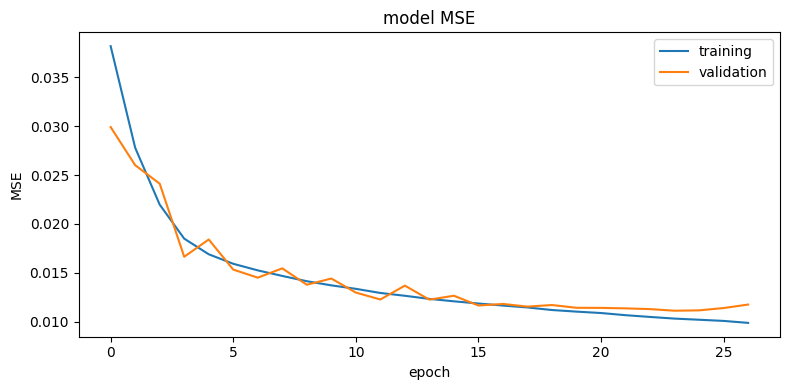

In [ ]:
plt.figure(figsize=(8, 4))
display_training_curves(history_df['loss'], history_df['val_loss'], 'MSE',111)
plt.tight_layout()

174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


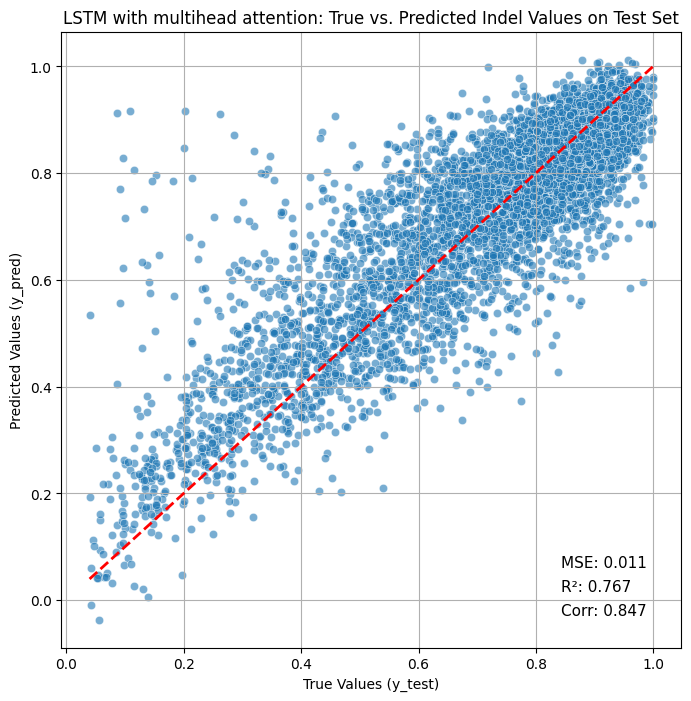

In [ ]:
y_pred = model.predict(X_test_reshaped).flatten()

mse = model.evaluate(X_test_reshaped, y_test, verbose=0)
r2 = r2_score(y_test, y_pred)
scorr = spearmanr(y_test, y_pred).correlation

plot_prediction(y_test, y_pred, title='LSTM with multihead attention: True vs. Predicted Indel Values on Test Set', r2=r2, mse=mse, scorr=scorr)

In [ ]:
results_df = pd.DataFrame({'True_Value': y_test, 'Predicted_Value': y_pred}, index=y_test.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 60
       True_Value  Predicted_Value
37780    0.152561         0.796121
8761     0.285496         0.628486
30991    0.372418         0.746062
42369    0.201679         0.915360
51135    0.355050         0.634687


Inspect hidden layer outputs of LSTM-multihead attention model

In [ ]:
layer_name = 'flatten_1'
layer_output = model.get_layer(layer_name).output
intermediate_model = models.Model(
    inputs=model.inputs, outputs=layer_output
)
activations = intermediate_model.predict(X_test_reshaped)

174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


In [ ]:
activation_data = {}
for k in range(0,1344):
    activation_data[f"act_val_{k}"] = activations[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
act_val_0,-0.079,0.050,0.149,0.036,0.095,0.021,-0.162,0.033,0.057,-0.007,-0.021,0.048,-0.022,-0.021,-0.116
act_val_1,-0.004,0.194,0.174,0.278,0.214,0.173,0.106,0.166,0.152,-0.001,0.178,0.136,0.267,0.214,-0.035
act_val_2,-0.030,-0.061,-0.042,-0.058,-0.053,-0.029,-0.022,-0.044,-0.011,-0.004,0.076,0.066,-0.044,-0.033,-0.005
act_val_3,0.087,0.061,-0.067,0.017,-0.033,0.035,0.131,0.006,0.081,0.140,0.136,0.115,-0.012,0.131,0.127
act_val_4,-0.021,0.088,0.136,0.157,0.096,0.148,0.019,0.107,0.064,-0.004,-0.058,0.046,0.127,0.097,-0.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
act_val_1339,-0.003,0.030,-0.158,0.212,-0.056,-0.113,0.123,-0.073,-0.059,-0.169,-0.056,-0.110,0.057,0.093,-0.026
act_val_1340,-0.024,0.160,-0.012,0.031,-0.090,0.001,-0.149,0.118,0.042,0.011,-0.040,-0.024,0.173,-0.098,-0.023
act_val_1341,0.079,0.216,0.288,-0.041,0.115,0.228,-0.033,0.302,0.219,0.249,0.113,0.118,0.159,0.076,0.029
act_val_1342,-0.035,0.213,0.086,0.173,0.021,0.069,0.030,0.238,0.114,0.053,-0.167,-0.128,0.241,0.123,-0.163


In [ ]:
%%time
tsne = TSNE(n_components=2
            ,init='pca'
            ,learning_rate='auto'
            ,verbose=0
            ,perplexity=30, max_iter=300)
tsne_results = tsne.fit_transform(activation_df)

CPU times: user 24.1 s, sys: 41.4 ms, total: 24.1 s
Wall time: 24.3 s


In [ ]:
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

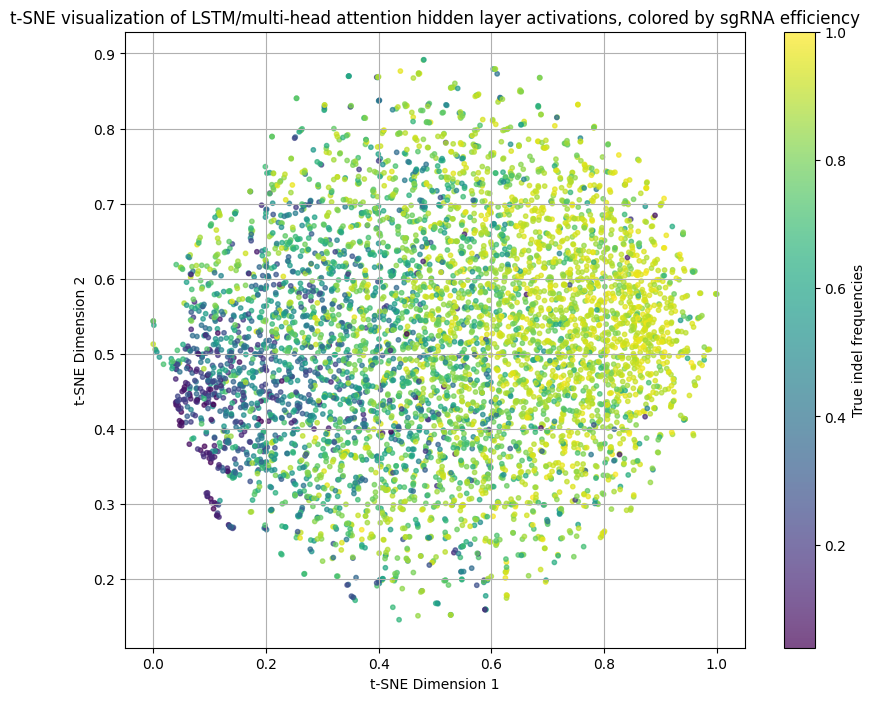

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(scatter, label='True indel frequencies')
plt.title('t-SNE visualization of LSTM/multi-head attention hidden layer activations, colored by sgRNA efficiency')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()